# This notebook reads cryptocurrency data from API and stores the data in Neo4j graph databases using Py2Neo

<!-- The name of this notebook should in the following format: -->
<!-- - if the notebook is exploring `pycaret API`, then it is `pycaret.API.ipynb` -->

<!-- Follow the reference to write notebooks in a clear manner: https://github.com/causify-ai/helpers/blob/master/docs/coding/all.jupyter_notebook.how_to_guide.md -->

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import logging
# Import libraries in this section.
# Avoid imports like import *, from ... import ..., from ... import *, etc.

# import helpers.hdbg as hdbg
# import helpers.hprint as hprint
import requests
import pandas as pd
import matplotlib.pyplot as plt
from py2neo import Graph, Node
import os

In [3]:
graph = Graph(os.getenv("NEO4J_URI"), auth=(os.getenv("NEO4J_USER"), os.getenv("NEO4J_PASS")))

## Configuration

In [ ]:
# hdbg.init_logger(verbosity=logging.INFO)

# _LOG = logging.getLogger(__name__)

# hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-085a2ce7-6161-4c8a-92d5-492051832f3c.json'


## Make the notebook flow clear
Each notebook needs to follow a clear and logical flow, e.g:
- Load data
- Compute stats
- Clean data
- Compute stats
- Do analysis
- Show results

In [12]:
import requests
from py2neo import Graph, Node, Relationship

class Template:
    """
    Class to handle Bitcoin API data fetching and Neo4j graph insertion.
    """

    def __init__(self, graph):
        self.graph = graph

    def fetch_price_volume(self, limit=10):
        url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
        params = {
            "vs_currency": "usd",
            "days": "1"
        }

        response = requests.get(url, params=params)
        if response.status_code != 200:
            raise ValueError(f"API request failed: {response.status_code} - {response.text}")

        data = response.json()
        print("Response keys:", data.keys())  # Should include 'prices' and 'total_volumes'

        if "prices" not in data or "total_volumes" not in data:
            raise KeyError("Missing expected keys in CoinGecko response.")

        prices = data["prices"][:limit]
        volumes = data["total_volumes"][:limit]

        addresses = [f"wallet_{i}" for i in range(5)]
        transactions = []

        for i in range(len(prices)):
            sender = addresses[i % 5]
            receiver = addresses[(i + 1) % 5]
            timestamp = int(prices[i][0] / 1000)
            amount = round(volumes[i][1] / prices[i][1], 5)
            transactions.append({
                "sender": sender,
                "receiver": receiver,
                "amount": amount,
                "timestamp": timestamp
            })

        return transactions


    def insert_transactions(self, transactions):
        for tx in transactions:
            sender_node = Node("Address", address=tx["sender"])
            receiver_node = Node("Address", address=tx["receiver"])

            self.graph.merge(sender_node, "Address", "address")
            self.graph.merge(receiver_node, "Address", "address")

            tx_rel = Relationship(sender_node, "SENT", receiver_node,
                                  amount=tx["amount"], timestamp=tx["timestamp"])
            self.graph.create(tx_rel)

In [13]:
template = Template(graph)
transactions = template.fetch_price_volume(limit=15)
template.insert_transactions(transactions)

Response keys: dict_keys(['prices', 'market_caps', 'total_volumes'])


In [14]:
def get_top_senders(graph):
    return graph.run("""
        MATCH (a:Address)-[:SENT]->()
        RETURN a.address AS sender, count(*) AS tx_count
        ORDER BY tx_count DESC
        LIMIT 5
    """).to_data_frame()

In [15]:
def get_frequent_pairs(graph):
    return graph.run("""
        MATCH (a:Address)-[r:SENT]->(b:Address)
        RETURN a.address AS sender, b.address AS receiver, count(*) AS tx_count
        ORDER BY tx_count DESC
        LIMIT 10
    """).to_data_frame()

In [16]:
def get_mutual_transactions(graph):
    return graph.run("""
        MATCH (a:Address)-[:SENT]->(b:Address)
        MATCH (b)-[:SENT]->(a)
        RETURN DISTINCT a.address AS one, b.address AS two
        LIMIT 10
    """).to_data_frame()

In [17]:
top_senders = get_top_senders(graph)
print(top_senders)

     sender  tx_count
0  wallet_0         1
1  wallet_1         1
2  wallet_2         1
3  wallet_3         1
4  wallet_4         1


In [18]:
frequent_pairs = get_frequent_pairs(graph)
print(frequent_pairs)

     sender  receiver  tx_count
0  wallet_0  wallet_1         1
1  wallet_1  wallet_2         1
2  wallet_2  wallet_3         1
3  wallet_3  wallet_4         1
4  wallet_4  wallet_0         1


In [19]:
mutual_tx = get_mutual_transactions(graph)
print(mutual_tx)

Empty DataFrame
Columns: []
Index: []


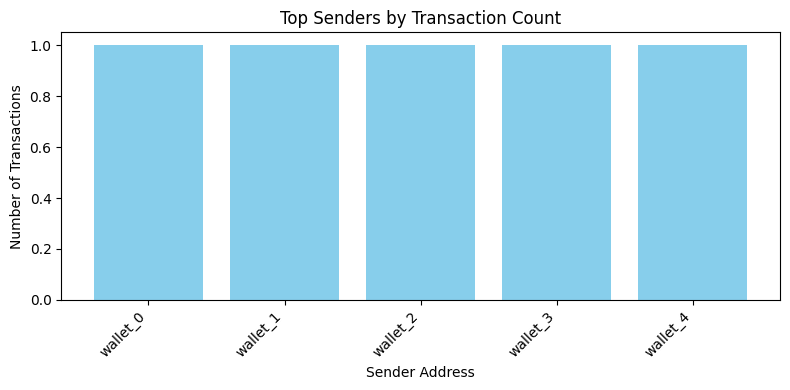

In [20]:
def plot_top_senders(df):
    plt.figure(figsize=(8, 4))
    plt.bar(df["sender"], df["tx_count"], color="skyblue")
    plt.title("Top Senders by Transaction Count")
    plt.xlabel("Sender Address")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
plot_top_senders(top_senders)

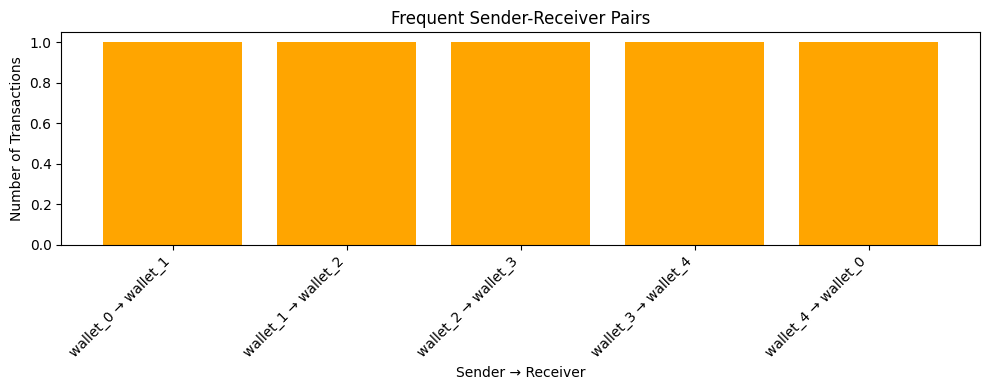

In [23]:
def plot_frequent_pairs_bar(df):
    if df.empty:
        print("No frequent pairs to plot.")
        return

    df["pair"] = df["sender"] + " → " + df["receiver"]
    plt.figure(figsize=(10, 4))
    plt.bar(df["pair"], df["tx_count"], color="orange")
    plt.title("Frequent Sender-Receiver Pairs")
    plt.xlabel("Sender → Receiver")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_frequent_pairs_bar(frequent_pairs)